# Explore GISAID data


In [22]:
import os
import math
import pickle
import numpy as np
import torch
from pprint import pprint
from collections import Counter, defaultdict
from pyrocov import mutrans, pangolin, geo
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"

## Explore columns

In [2]:
with open("results/usher.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("loaded {} rows".format(len(columns["day"])))
print(list(columns.keys()))

loaded 4388114 rows
['clade', 'clades', 'lineage', 'lineages', 'virus_name', 'accession_id', 'collection_date', 'location', 'add_location', 'day']


In [33]:
%%time
pprint(sorted(Counter(map(geo.gisaid_normalize, columns["location"])).items()))

[('Africa / Algeria / Adrar', 1),
 ('Africa / Algeria / Alger', 3),
 ('Africa / Algeria / Algiers', 13),
 ('Africa / Algeria / Blida', 5),
 ('Africa / Algeria / Bordj Bou Arreridj', 1),
 ('Africa / Algeria / Boufarik', 2),
 ('Africa / Algeria / Bouira', 5),
 ('Africa / Algeria / Eddis', 1),
 ('Africa / Algeria / El Oued', 2),
 ('Africa / Algeria / Laghouat', 2),
 ('Africa / Algeria / Medea', 1),
 ('Africa / Algeria / Oran', 1),
 ('Africa / Algeria / Ouargla', 3),
 ('Africa / Algeria / Setif', 1),
 ('Africa / Algeria / Sidi Bel Abbes', 3),
 ('Africa / Algeria / Tipaza', 1),
 ('Africa / Algeria / Tizi Ouzou', 1),
 ('Africa / Algeria / Touggourt', 1),
 ('Africa / Angola / Bie', 4),
 ('Africa / Angola / C Cubango', 2),
 ('Africa / Angola / Cabinda', 16),
 ('Africa / Angola / Capalacassa', 1),
 ('Africa / Angola / Cunene', 6),
 ('Africa / Angola / Huambo', 37),
 ('Africa / Angola / Huila', 1),
 ('Africa / Angola / Luanda', 345),
 ('Africa / Angola / Zaire', 1),
 ('Africa / Benin / Come', 2)

 ('Europe / Belgium / Grez Doiceau', 9),
 ('Europe / Belgium / Grimbergen', 41),
 ('Europe / Belgium / Grimmige', 1),
 ('Europe / Belgium / Grivegnee', 2),
 ('Europe / Belgium / Grobbendonk', 27),
 ('Europe / Belgium / Groot Bijgaarden', 18),
 ('Europe / Belgium / Grote Brogel', 6),
 ('Europe / Belgium / Gruitrode', 1),
 ('Europe / Belgium / Guignies', 1),
 ('Europe / Belgium / Gullegem', 30),
 ('Europe / Belgium / Haacht', 89),
 ('Europe / Belgium / Haaltert', 5),
 ('Europe / Belgium / Haasdonk', 1),
 ('Europe / Belgium / Haasrode', 28),
 ('Europe / Belgium / Hainaut', 2210),
 ('Europe / Belgium / Halen', 22),
 ('Europe / Belgium / Hallaar', 14),
 ('Europe / Belgium / Halle', 269),
 ('Europe / Belgium / Halle Booienhoven', 1),
 ('Europe / Belgium / Ham', 28),
 ('Europe / Belgium / Ham San Heune', 1),
 ('Europe / Belgium / Ham Sur Heure', 1),
 ('Europe / Belgium / Ham Sur Heure Nalinnes', 6),
 ('Europe / Belgium / Hamme', 10),
 ('Europe / Belgium / Hamme (o. Vl.)', 2),
 ('Europe / Belg

 ('Europe / Liechtenstein / Schaanwald', 1),
 ('Europe / Liechtenstein / Schellenberg', 2),
 ('Europe / Liechtenstein / Triesen', 1),
 ('Europe / Liechtenstein / Vaduz', 3),
 ('Europe / Lithuania', 31),
 ('Europe / Lithuania / Alytaus', 668),
 ('Europe / Lithuania / Alytus', 282),
 ('Europe / Lithuania / Ignalina', 1),
 ('Europe / Lithuania / Jonava', 2),
 ('Europe / Lithuania / Jonavos', 17),
 ('Europe / Lithuania / Kaisiadorys', 5),
 ('Europe / Lithuania / Kaunas', 514),
 ('Europe / Lithuania / Kauno', 2207),
 ('Europe / Lithuania / Kedainiai', 2),
 ('Europe / Lithuania / Klaipeda', 216),
 ('Europe / Lithuania / Klaipedos', 1646),
 ('Europe / Lithuania / Kretingos', 1),
 ('Europe / Lithuania / Marijampole', 83),
 ('Europe / Lithuania / Marijampoles', 742),
 ('Europe / Lithuania / Moletu', 1),
 ('Europe / Lithuania / Panevezio', 772),
 ('Europe / Lithuania / Panevezys', 121),
 ('Europe / Lithuania / Prienai', 1),
 ('Europe / Lithuania / Radviliskio', 3),
 ('Europe / Lithuania / Siauli

 ('North America / Mexico / Unknown', 1),
 ('North America / Mexico / Veracruz', 1266),
 ('North America / Mexico / Yucatan', 2123),
 ('North America / Mexico / Zacatecas', 622),
 ('North America / Montserrat', 4),
 ('North America / Montserrat / Caribbean', 2),
 ('North America / Panama', 19),
 ('North America / Panama / Bocas Del Toro', 9),
 ('North America / Panama / Chiriqui', 52),
 ('North America / Panama / Cocle', 64),
 ('North America / Panama / Colon', 93),
 ('North America / Panama / Comarca Ngobe Bugle', 5),
 ('North America / Panama / Darien', 12),
 ('North America / Panama / Guna Yala', 33),
 ('North America / Panama / Herrera', 7),
 ('North America / Panama / Los Santos', 18),
 ('North America / Panama / Metropolitan', 130),
 ('North America / Panama / Metropolitana', 71),
 ('North America / Panama / Na', 1),
 ('North America / Panama / Panama', 2),
 ('North America / Panama / Panama Center', 107),
 ('North America / Panama / Panama East', 10),
 ('North America / Panama /

In [34]:
countries = Counter()
regions = defaultdict(Counter)
for location in columns["location"]:
    location = geo.gisaid_normalize(location)
    parts = location.split(" / ")
    location = " / ".join(parts[:3])
    country = " / ".join(parts[:2])
    countries[country] += 1
    regions[country][location] += 1
print("Total Regions")
print("------------------------------------------------------")
for c, count in countries.most_common():
    rs = " ".join(str(v) for k, v in regions[c].most_common())
    print(f"{c}\n{count}\t{rs}")

Total Regions
------------------------------------------------------
North America / USA
1353842	218112 100195 84994 73655 57027 55344 54019 50729 35573 35137 34175 32626 32038 28293 28139 28114 28027 26347 22322 20279 19921 18951 18867 17641 16049 14827 14069 13561 12993 12839 11643 11412 11111 10245 8519 7889 7843 7694 7598 7433 7218 6657 6627 6063 5761 5737 5135 4105 3653 2626 1868 812 579 307 188 133 73 30 20
Europe / United Kingdom
1072199	864180 110882 88983 8141 9 2 1 1
Europe / Germany
239113	63984 32144 28661 18317 18204 11394 11349 10140 9185 8057 6397 6252 4821 2997 2992 2692 1487 18 11 7 3 1
Europe / Denmark
187632	87405 33109 27354 21962 15357 2445
North America / Canada
168769	66920 37924 24790 19100 12790 3545 1657 1459 569 15
Asia / Japan
156110	27069 12069 10976 10369 10317 9391 8399 7002 5182 4228 3028 2686 2647 2620 2512 2376 2256 2217 1932 1774 1768 1655 1598 1524 1505 1500 1406 1317 1294 1255 1239 1137 1012 993 752 735 727 623 582 523 521 514 498 485 472 428 393 27

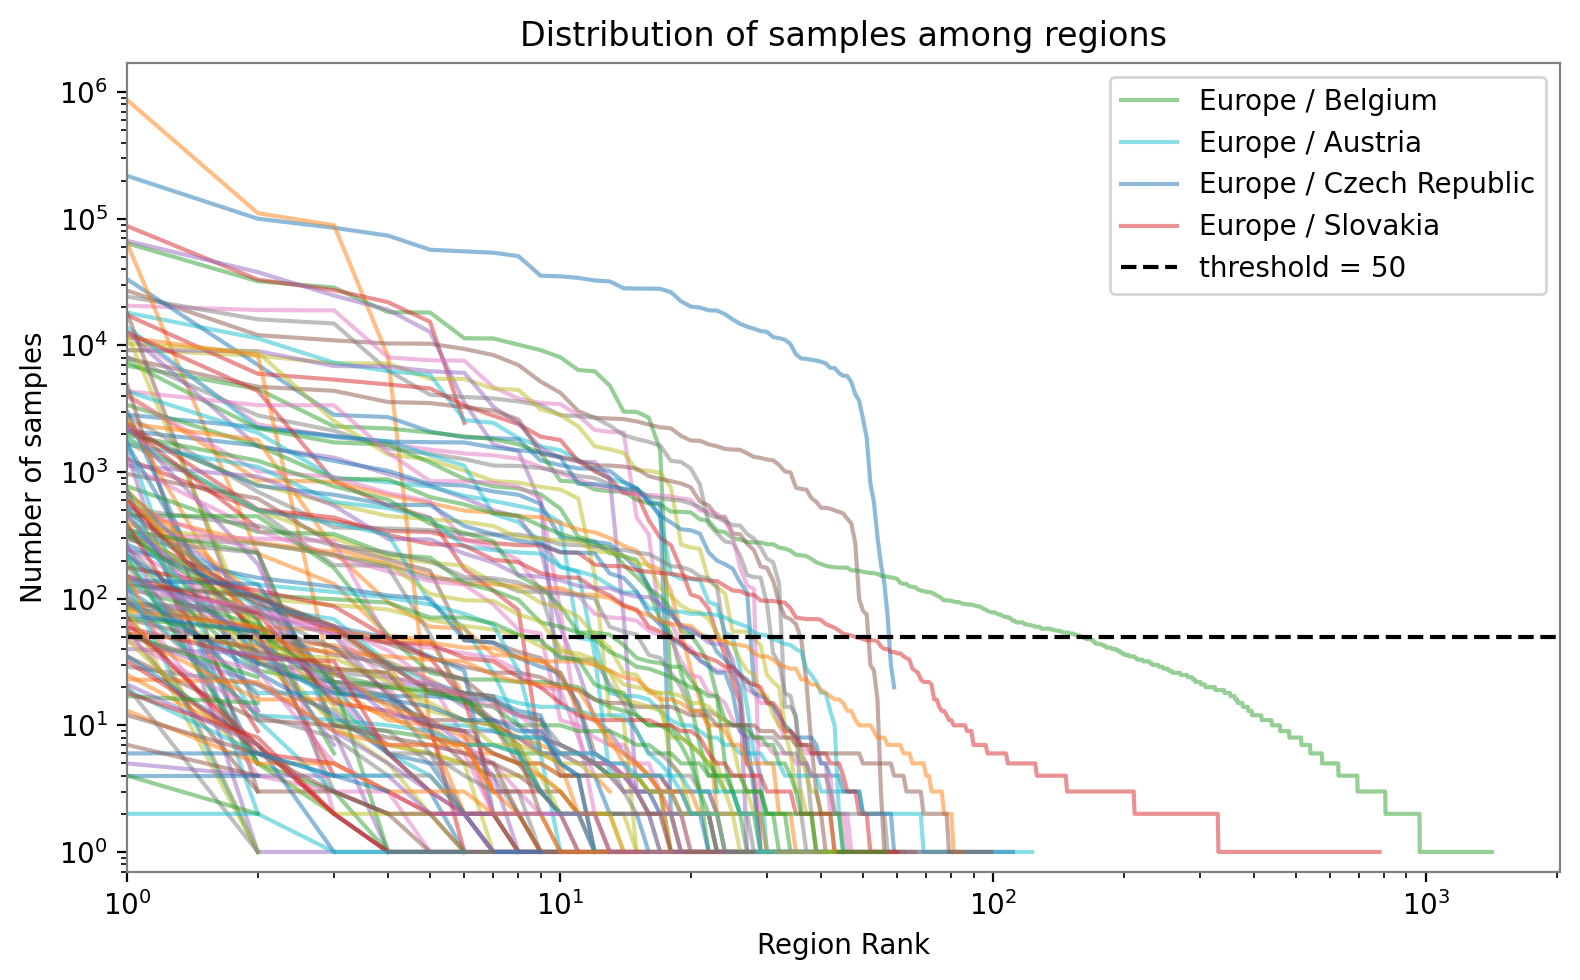

In [67]:
plt.figure(figsize=(8, 5))
for c, count in countries.most_common():
    Y = [v for k, v in regions[c].most_common()]
    X = torch.arange(1, 1 + len(Y))
    plt.plot(X, Y, alpha=0.5, label=c if len(Y) > 100 else None)
plt.axhline(50, color="k", linestyle="--", label="threshold = 50")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1, None)
plt.ylim(0.7, None)
plt.legend(loc="upper right")
plt.title("Distribution of samples among regions")
plt.xlabel("Region Rank")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.savefig("paper/region_distribution.png")

In [36]:
strain_counts = Counter(columns["lineage"])
for strain, count in strain_counts.most_common(20):
    short = pangolin.compress(strain)
    long = pangolin.decompress(strain)
    assert strain == short, (strain, long)
    if short == long:
        print(f"{count: >10d} {short}")
    else:
        print(f"{count: >10d} {short} (aka {long})")

    981333 B.1.1.7
    562154 B.1.617.2
    548372 AY.4 (aka B.1.617.2.4)
    136082 AY.25 (aka B.1.617.2.25)
    132403 AY.43 (aka B.1.617.2.43)
    131884 AY.44 (aka B.1.617.2.44)
    100826 B.1.2
     98328 B.1
     83478 AY.3 (aka B.1.617.2.3)
     68183 B.1.177
     61842 AY.29 (aka B.1.617.2.29)
     56369 P.1 (aka B.1.1.28.1)
     43478 B.1.1
     41477 AY.5 (aka B.1.617.2.5)
     39619 AY.4.2 (aka B.1.617.2.4.2)
     37962 B.1.526
     36458 B.1.429
     31534 AY.9.2 (aka B.1.617.2.9.2)
     29379 AY.26 (aka B.1.617.2.26)
     29060 AY.39 (aka B.1.617.2.39)


Text(0.5, 1.0, 'Distribution of samples among lineages')

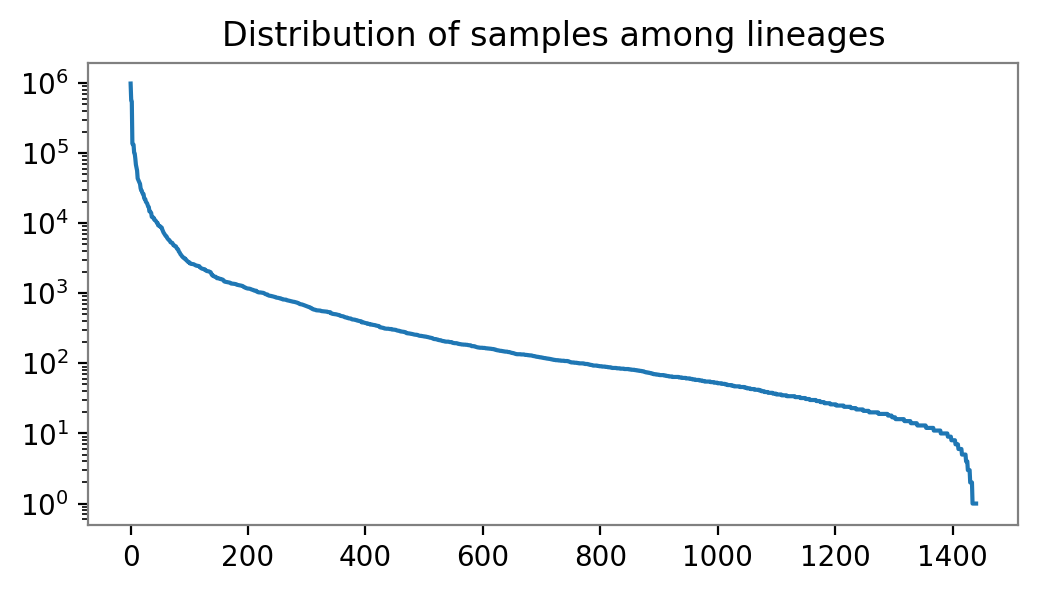

In [37]:
plt.figure(figsize=(6,3))
plt.plot([c for _, c in strain_counts.most_common()])
plt.yscale("log")
plt.title("Distribution of samples among lineages")

In [55]:
%%time
clade_counts = {}
for max_num_clades in [2000, 5000, 10000]:
    with open(f"results/columns.{max_num_clades}.pkl", "rb") as f:
        counts = Counter(pickle.load(f)["clade"])
        clade_counts[max_num_clades] = counts
        print((max_num_clades, len(counts)))

(2000, 65325)
(5000, 68315)
(10000, 73296)
CPU times: user 14.9 s, sys: 5.77 s, total: 20.7 s
Wall time: 21.5 s


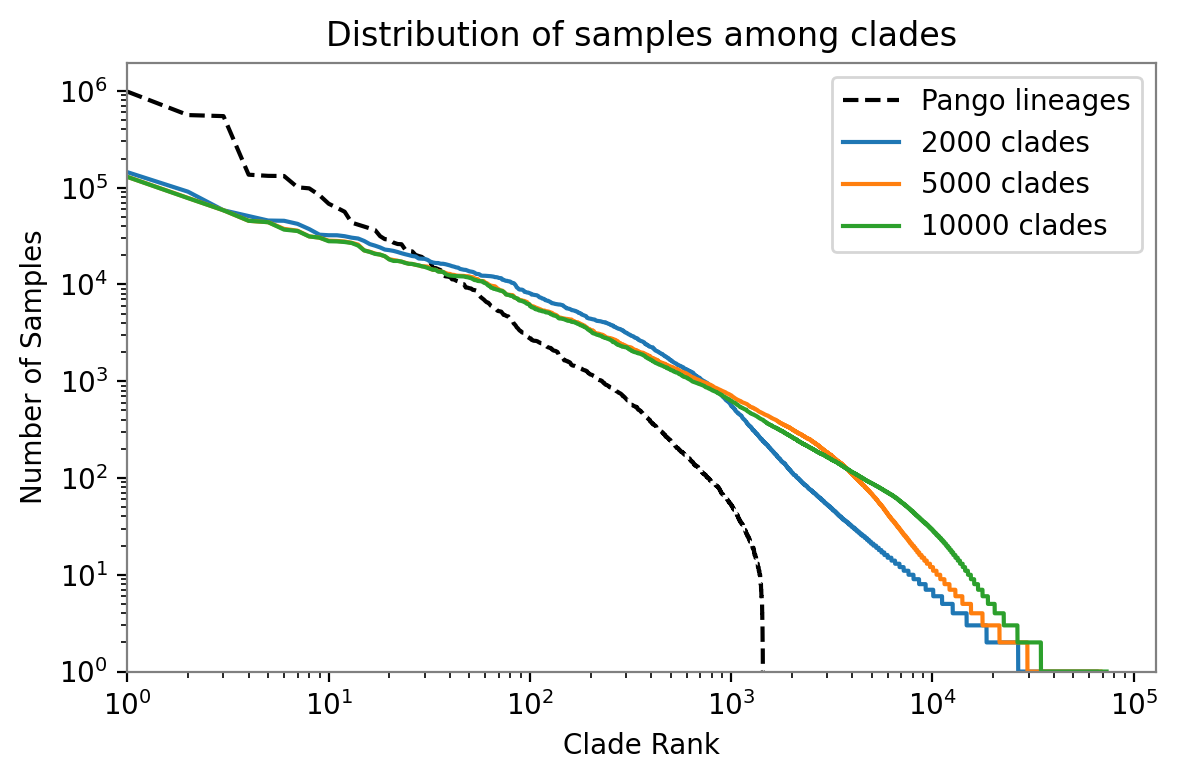

In [60]:
plt.figure(figsize=(6,4))
Y = [c for _, c in strain_counts.most_common()]
plt.plot(torch.arange(1,1 + len(Y)), Y, "k--", label="Pango lineages")
for k, v in clade_counts.items():
    Y = [c for _, c in v.most_common()]
    plt.plot(torch.arange(1,1 + len(Y)), Y, label=f"{k} clades")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1, None)
plt.ylim(1, None)
plt.xlabel("Clade Rank")
plt.ylabel("Number of Samples")
plt.legend(loc="upper right")
plt.title("Distribution of samples among clades")
plt.tight_layout()
plt.savefig("paper/clade_distribution.png")

In [38]:
counts = Counter()
for location in columns["location"]:
    parts = location.split("/")
    if len(parts) < 2:
        continue
    parts = tuple(p.strip() for p in parts[:3])
    counts[parts] += 1

In [ ]:
plt.figure(figsize=(6,3))
plt.plot([c for _, c in counts.most_common()])
plt.yscale("log")
plt.title("Distribution of samples among regions")

In [ ]:
fine_countries = set()
for parts, count in counts.items():
    if count >= 5000:
        fine_countries.add(parts[1])
fine_countries = list(sorted(fine_countries))
print("\n".join(fine_countries))

In [ ]:
locations = Counter(columns["location"])
print("\n".join(f"{c}\t{p}" for p, c in locations.most_common() if "United Kingdom" in p))

In [ ]:
print("Europe:", sum(1 for l in columns["location"] if "Europe" in l))
print("World - Europe:", sum(1 for l in columns["location"] if "Europe" not in l))

## When were lineages born?

In [ ]:
days = []
for lineage, day in zip(columns["lineage"], columns["day"]):
    if lineage == "B.1.1.7":
        days.append(day)

In [ ]:
plt.hist(np.array(days), bins=50)
plt.yscale("log")
plt.title("Distribution of dates of B.1.1.7");

In [ ]:
pdf = torch.zeros(max(days) + 1).scatter_add(0, torch.tensor(days), torch.ones(len(days)))
pdf /= pdf.sum()
cdf = pdf.cumsum(0)

In [ ]:
plt.plot(cdf)
plt.yscale("log")
plt.title("CDF of B.1.1.7 observations")

## Explore count data

In [ ]:
def load_data():
    filename = "results/mutrans.data.single.pt"
    if os.path.exists(filename):
        dataset = torch.load(filename)
    else:
        dataset = mutrans.load_gisaid_data()
        torch.save(dataset, filename)
    dataset.update(mutrans.load_jhu_data(dataset))
    return dataset

dataset = load_data()
locals().update(dataset)
for k, v in sorted(dataset.items()):
    if isinstance(v, torch.Tensor):
        print(f"{k} \t{type(v).__name__} of shape {tuple(v.shape)}")
    else:
        print(f"{k} \t{type(v).__name__} of size {len(v)}")

In [ ]:
daily_cases.shape

In [ ]:
probs = weekly_clades + 1 / weekly_clades.size(-1)
probs /= probs.sum(-1, True)
logits = probs.log()
logits -= logits.median(-1, True).values
plt.hist(logits.reshape(-1).numpy(), bins=100)
plt.yscale("symlog");

In [ ]:
logits -= logits.mean(-1, True)
plt.hist(logits.reshape(-1).numpy(), bins=100)
plt.yscale("symlog");

## How heterogeneous are lineages?

In [ ]:
def plot_agreement(pairs):
    M = int(len(pairs) ** 0.5 + 0.5)
    N = int(math.ceil(len(pairs) / M))
    assert len(pairs) <= M * N
    fig, axes = plt.subplots(M, N, figsize=(2 * N, 2 * M + 0.5))
    fig.suptitle("Mutation correlation between parent-child lineage pairs", y=0.91)
    pairs = iter(pairs)
    for axe in axes:
        for ax in axe:
            ax.set_xticks(())
            ax.set_yticks(())
            ax.set_xlim(-0.05, 1.05)
            ax.set_ylim(-0.05, 1.05)
            try:
                x, y = next(pairs)
            except StopIteration:
                continue
            ax.set_xlabel(x)
            ax.set_ylabel(y)
            X = dataset["features"][dataset["lineage_id"][x]]
            Y = dataset["features"][dataset["lineage_id"][y]]
            ax.scatter(X.numpy(), Y.numpy(), alpha=0.3, lw=0)
            X = (X - X.mean()) / X.std()
            Y = (Y - Y.mean()) / Y.std()
            ax.text(0.5, 0.5, "{:0.3g}".format((X * Y).mean()),
                    va="center", ha="center")
plot_agreement([
    # Alpha
    ("A", "B"),
    ("B", "B.1"),
    ("B.1", "B.1.1"),
    ("B.1.1", "B.1.1.7"),
    # Beta
    ("B.1", "B.1.351"),
    ("B.1", "B.1.351.2"),
    ("B.1", "B.1.351.3"),
    # Gamma
    ("B.1.1", "P.1"),
    ("P.1", "P.1.1"),
    ("P.1", "P.1.2"),
    # Delta
    # ("B.1.617", "B.1.617.1"),
    # ("B.1.617", "B.1.617.2"),
    # ("B.1.617", "B.1.617.3"),
    ("B.1", "B.1.617.1"),
    ("B.1", "B.1.617.2"),
    ("B.1", "B.1.617.3"),
    ("B.1.617.2", "AY.1"),
    # Epsilon
    ("B.1", "B.1.427"),
])